Ici pour aller plus loin : utilisation de piellines, et introduction de nouvelles variables afin de tenter d'améliorer le modéle.

In [3]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd

In [ ]:
from scipy import spatial

import pysal
from pysal.cg.kdtree import KDTree

# Creating new predictors

In [17]:
df_trees=pd.read_pickle('trees_first_clean.pkl')
df_trees.head()

,CODE,CATEGORIE_DESC,SOUS_CATEGORIE,SOUS_CATEGORIE_DESC,CODE_PARENT_DESC,ADR_SECTEUR,GENRE_BOTA,ESPECE,VARIETE,STADEDEDEVELOPPEMENT,COLLECTIVITE,LON,LAT,ANNEEDEPLANTATION
0,ESP32632,Arbre,ESP174,Arbre d'espaces ouverts,Prc Echangeurs Bastion St Roch,5,Acer,pseudoplatanus,NaN,Arbre adulte,Ville de Grenoble,5.740727,45.190539,2001.0
1,ESP32631,Arbre,ESP174,Arbre d'espaces ouverts,Prc Echangeurs Bastion St Roch,5,Acer,pseudoplatanus,NaN,Arbre adulte,Ville de Grenoble,5.740748,45.190525,2001.0
2,ESP32630,Arbre,ESP174,Arbre d'espaces ouverts,Prc Echangeurs Bastion St Roch,5,Acer,pseudoplatanus,NaN,Arbre adulte,Ville de Grenoble,5.740697,45.190498,2001.0
3,ESP32629,Arbre,ESP174,Arbre d'espaces ouverts,Prc Echangeurs Bastion St Roch,5,Acer,pseudoplatanus,NaN,Arbre adulte,Ville de Grenoble,5.740675,45.190491,2001.0
4,ESP32628,Arbre,ESP174,Arbre d'espaces ouverts,Prc Echangeurs Bastion St Roch,5,Acer,pseudoplatanus,NaN,Arbre adulte,Ville de Grenoble,5.740702,45.190479,2001.0


In [11]:
from sklearn.model_selection import train_test_split

df_trees_Y=df_trees.pop('ANNEEDEPLANTATION')

#Important!!! Use the same parameters -> 20%, random seed generator=41.
df_trees_train, df_trees_test, df_trees_train_Y, df_trees_test_Y = train_test_split(df_trees, df_trees_Y, test_size=0.2, random_state=41)

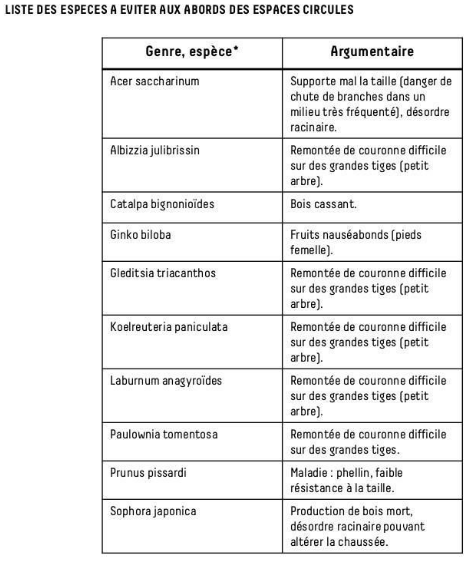

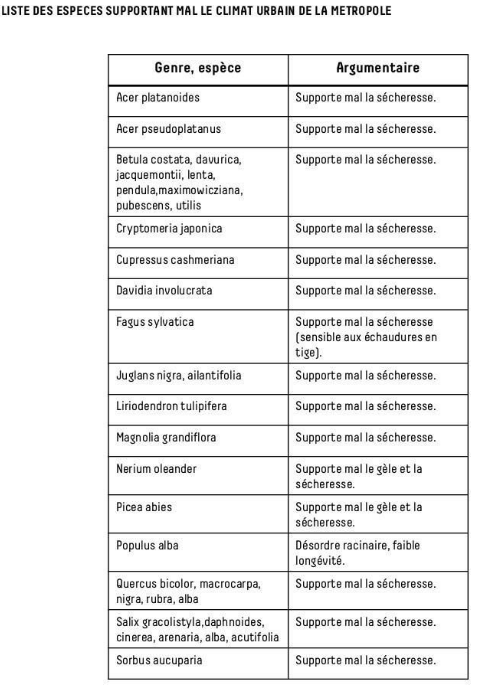

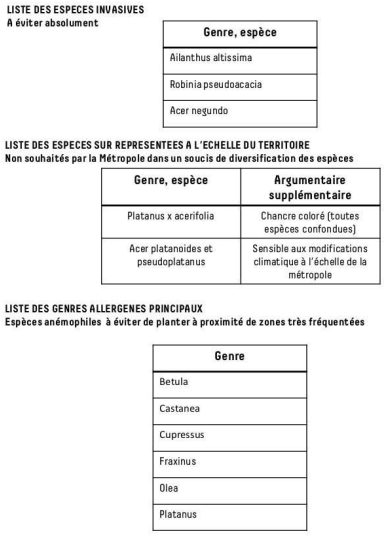

In [6]:
set_genre_non_desiree = {'Aesculus','Fraxinus','Platanus','Betula','Castanea','Cupressus','Olea' }
set_especes_non_desiree = {'Acer saccharinum',
                            'Albizzia julibrissin',
                            'Catalpa bignonoides',
                            'Ginkgo biloba',
                            'Gleditsia triacanthos',
                            'Koelreuteria paniculata',
                            'Laburnum anagyroides',
                            'Paulownia tomentosa',
                            'Prunus pissardi',
                            'Sophora japonica',
                            'Acer palmatum',
                            'Acer pseudoplatanus',
                           'Cryptomeria japonica',
                            'Davidia involucrata',
                           'Fagus sylvatica',
                           'Juglans nigra',
                           'Juglans ailantifolia',
                            'Liriodendron tulipifera',
                           'Magnolia grandiflora',
                           'Nerium oleander',
                           'Picea abies',
                           'Populus alba',
                           'Quercus bicolor',
                           'Quercus macrocarpa',
                           'Quercus nigra',
                           'Quercus rubra',
                           'Quercus alba',
                           'Salix alba',
                           'Salix gracolistyla',
                           'Salix daphnoides',
                           'Salix cinerea',
                           'Salix arenaria',
                           'Salix acutifolia',
                           'Sorbus aucuparia',
                            'Acer platanoides',
                            'Acer pseudoplatanus',
                           'Platanus acrifolia'
                          }
set_espece_absolument_non_desiree={'Ailanthus altissima','Robinia pseudoacacia',
                            'Acer negundo',}

In [79]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

#Custom transformers
class MergingTextColumns(BaseEstimator, TransformerMixin):
    def __init__(self,list_columns=[],space=True,drop=False,name='MergedTextColumn'): # no *args or **kargs
        self.list_columns=list_columns
        self.space=space
        self.name=name
        self.drop=drop
    def fit(self,X,Y=None):
        return self
    def transform(self,X):
        Xc=X.copy()
        if self.space:
            Xc[self.name]=Xc[self.list_columns[0]]+' '+Xc[self.list_columns[1]]
        else:
            Xc[self.name]=Xc[self.list_columns[0]]+Xc[self.list_columns[1]]
        if self.drop:
            Xc.drop(self.list_columns,inplace=True,axis=1)
        return Xc

class WantedTrees(BaseEstimator, TransformerMixin):
    def __init__(self,column='',species_unwanted={},undesirable={}): # no *args or **kargs
        self.column=column
        self.species_unwanted=species_unwanted
        self.undesirable=undesirable
    def encoding(self,spe):
        if spe in self.species_unwanted:
            return 1
        elif spe in self.undesirable:
            return 2
        else:
            return 0
    def fit(self,X,Y=None):
        return self
    def transform(self,X):
        Xc=X.copy()
        Xc.ESPECE_SCIENTIFIQUE=Xc.ESPECE_SCIENTIFIQUE.apply(lambda x: self.encoding(x))
        return Xc

#Defining different attributes
# all_attribs = ['SOUS_CATEGORIE_DESC','STADEDEDEVELOPPEMENT','LON','LAT','ADR_SECTEUR']
num_attribs = ['LON','LAT','ADR_SECTEUR']
cat_attribs = ['SOUS_CATEGORIE_DESC','STADEDEDEVELOPPEMENT','GENRE_BOTA','ESPECE']

#Defining text pipeline: columns selecter, changing Nans by most frequent values, Encoding text values, standardizing
text_pipeline = Pipeline([
# ('selecter',SelectColumns(list_columns=cat_attribs)),
('merger',MergingTextColumns(list_columns=['GENRE_BOTA','ESPECE'],name='ESPECE_SCIENTIFIQUE',drop=True)),
('desirability',WantedTrees(species_unwanted=set_especes_non_desiree,undesirable=set_espece_absolument_non_desiree)),
('imputer',SimpleImputer(strategy="most_frequent")),
('cat_encoder',OrdinalEncoder()),
 ('std_scaler', StandardScaler())
])

#Defining num pipeline: columns selecter, changing Nans by most frequent values, standardizing
num_pipeline = Pipeline([
# ('selecter',SelectColumns(list_columns=num_attribs)),
('imputer',SimpleImputer(strategy="most_frequent")),
('std_scaler', StandardScaler())
])

#Full pipeline!!!
full_pipeline = ColumnTransformer([
("cat", text_pipeline, cat_attribs),
("num", num_pipeline, num_attribs)
])

# df_trees_train_na_tr = NA_pipeline.transform(df_trees_train)
df_trees_train_text_tr = text_pipeline.fit_transform(df_trees_train[cat_attribs])
df_trees_train_num_tr = num_pipeline.fit_transform(df_trees_train[num_attribs])
# columns_dropping = DropColumns(list_columns=all_attribs)
# df_trees_funky = columns_dropping.transform(df_trees_train)

In [82]:
columns=['SOUS_CATEGORIE_DESC','STADEDEDEVELOPPEMENT','ADR_SECTEUR','ESPECE_SCIENTIFIQUE','LAT','LON']
df_trees_train_prepared=pd.DataFrame(full_pipeline.fit_transform(df_trees_train),columns=columns)
df_trees_train_prepared.head(2)

,SOUS_CATEGORIE_DESC,STADEDEDEVELOPPEMENT,ADR_SECTEUR,ESPECE_SCIENTIFIQUE,LAT,LON
0,0.921530,-0.484789,-0.492739,0.769107,1.572357,-1.094627
1,-0.574919,-0.484789,-0.492739,0.582756,-0.935367,1.259713


In [86]:
df_trees_test_prepared=pd.DataFrame(full_pipeline.transform(df_trees_test),columns=columns)

# Trying best model (random tree) with new predictors

In [87]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=10, random_state=True)
regressor.fit(df_trees_train_prepared, df_trees_train_Y)
df_trees_test_Y_predict_rf = regressor.predict(df_trees_test_prepared)

In [88]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(df_trees_test_Y, df_trees_test_Y_predict_rf))
print('Mean Squared Error:', metrics.mean_squared_error(df_trees_test_Y, df_trees_test_Y_predict_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_trees_test_Y, df_trees_test_Y_predict_rf)))

Mean Absolute Error: 3.1953163516844696
Mean Squared Error: 58.093309778142974
Root Mean Squared Error: 7.62189673100751


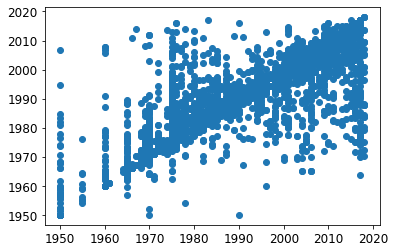

In [89]:
plt.scatter(df_trees_test_Y,df_trees_test_Y_predict_rf)

In [90]:
rf = RandomForestRegressor(random_state = True)

from pprint import pprint# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': True,
 'verbose': 0,
 'warm_start': False}


In [91]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000]}


In [92]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(df_trees_train_prepared, df_trees_train_Y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/campus-5/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 15.6min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [93]:
randomized_results = pd.DataFrame(rf_random.cv_results_)
randomized_results.sort_values(by=['rank_test_score'],inplace=True)
randomized_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
45,10.842819,0.037951,1.013696,0.005717,450,2,1,sqrt,110,True,"{'n_estimators': 450, 'min_samples_split': 2, ...",0.823626,0.821412,0.804064,0.816367,0.008747,1
17,10.743750,0.033290,0.980054,0.010470,450,2,1,sqrt,20,True,"{'n_estimators': 450, 'min_samples_split': 2, ...",0.819192,0.819762,0.802603,0.813852,0.007958,2
24,23.999402,0.206066,1.540124,0.012585,670,5,1,sqrt,80,False,"{'n_estimators': 670, 'min_samples_split': 5, ...",0.819550,0.820236,0.797027,0.812271,0.010783,3
21,28.138726,0.253904,1.799511,0.022496,780,5,1,sqrt,70,False,"{'n_estimators': 780, 'min_samples_split': 5, ...",0.819769,0.819876,0.797013,0.812219,0.010752,4
32,12.188667,0.124139,0.787942,0.015738,340,5,1,sqrt,100,False,"{'n_estimators': 340, 'min_samples_split': 5, ...",0.819132,0.819744,0.796544,0.811807,0.010795,5


In [94]:
df_trees_test_Y_predict_rf=rf_random.best_estimator_.predict(df_trees_test_prepared)
rf_random.best_params_

{'n_estimators': 450,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

In [95]:
print('Mean Absolute Error:', metrics.mean_absolute_error(df_trees_test_Y, df_trees_test_Y_predict_rf))
print('Mean Squared Error:', metrics.mean_squared_error(df_trees_test_Y, df_trees_test_Y_predict_rf))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_trees_test_Y, df_trees_test_Y_predict_rf)))

Mean Absolute Error: 3.190579993304725
Mean Squared Error: 48.526431972395756
Root Mean Squared Error: 6.966091585128332


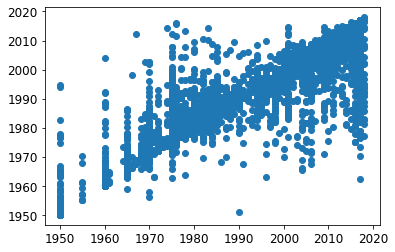

In [96]:
plt.scatter(df_trees_test_Y,df_trees_test_Y_predict_rf)

# ExtraTrees

In [99]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV

model = ExtraTreesRegressor()
param_grid = [
    {'n_estimators': range(1,20), 'max_features': range(1, len(df_trees_train_prepared.columns))},
    {'bootstrap': [False]},
]
gsc = GridSearchCV(
    model,
    param_grid,
    scoring='neg_mean_squared_error',
    cv=10
)
grid_result = gsc.fit(df_trees_train_prepared, df_trees_train_Y)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# grid_result.cv_results_

model = ExtraTreesRegressor(**grid_result.best_params_)
model.fit(df_trees_train_prepared, df_trees_train_Y)
df_trees_test_Y_predict_et = model.predict(df_trees_test_prepared)

Best: -39.294951 using {'bootstrap': False}


In [100]:
print('Mean Absolute Error:', metrics.mean_absolute_error(df_trees_test_Y, df_trees_test_Y_predict_et))
print('Mean Squared Error:', metrics.mean_squared_error(df_trees_test_Y, df_trees_test_Y_predict_et))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df_trees_test_Y, df_trees_test_Y_predict_et)))

Mean Absolute Error: 2.4820183511366722
Mean Squared Error: 42.86623672464164
Root Mean Squared Error: 6.547231225842084


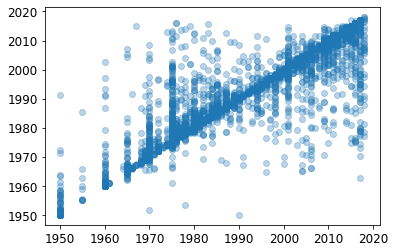

In [102]:
plt.scatter(df_trees_test_Y,df_trees_test_Y_predict_et,alpha=0.3)